Column Names: ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'VisitFrequency', 'Gender']
Dataset Shape: (1453, 15)
First Three Rows:
   yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  

Average values of transformed variables:
 yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting  

/var/folders/ns/_gksq54x6hq35t894m1570280000gn/T/ipykernel_5408/2757169144.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = mcdonalds.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0)


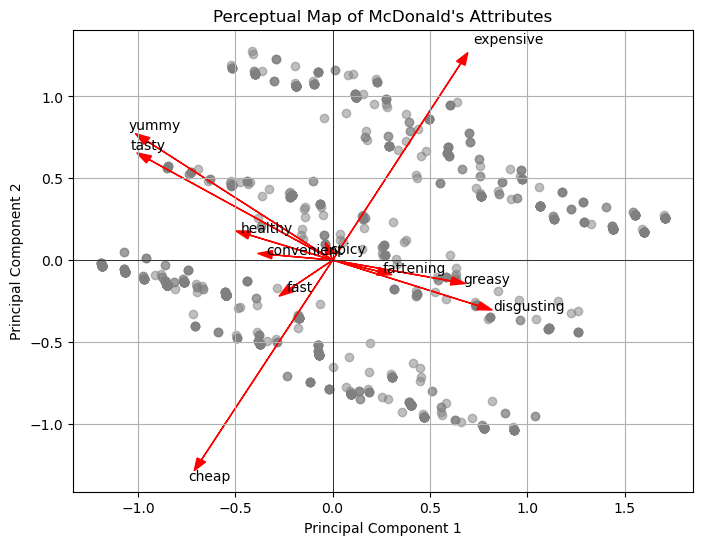

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

# Load dataset
#file_path = "/mnt/data/mcdonalds.csv"
mcdonalds = pd.read_csv("mcdonalds.csv")

# Inspect dataset
print("Column Names:", mcdonalds.columns.tolist())
print("Dataset Shape:", mcdonalds.shape)
print("First Three Rows:\n", mcdonalds.head(3))

# Convert segmentation variables from Yes/No to binary numeric
MD_x = mcdonalds.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0)
print("\nAverage values of transformed variables:\n", MD_x.mean().round(2))

# Perform Principal Component Analysis (PCA)
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

# Display explained variance
explained_variance = np.round(pca.explained_variance_ratio_, 4)
cumulative_variance = np.cumsum(explained_variance)
print("\nExplained Variance by Principal Components:\n", explained_variance)
print("Cumulative Variance:\n", cumulative_variance)

# Display principal component loadings
loadings = pd.DataFrame(pca.components_.T, index=MD_x.columns, columns=[f'PC{i+1}' for i in range(MD_x.shape[1])])
print("\nPCA Loadings:\n", loadings.round(2))

# Plot Perceptual Map (First Two Principal Components)
plt.figure(figsize=(8, 6))
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='grey', alpha=0.5)
for i, txt in enumerate(MD_x.columns):
    plt.arrow(0, 0, loadings.iloc[i, 0]*2, loadings.iloc[i, 1]*2, color='red', head_width=0.05)
    plt.text(loadings.iloc[i, 0]*2.2, loadings.iloc[i, 1]*2.2, txt, color='black')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Perceptual Map of McDonald's Attributes")
plt.grid()
plt.show()


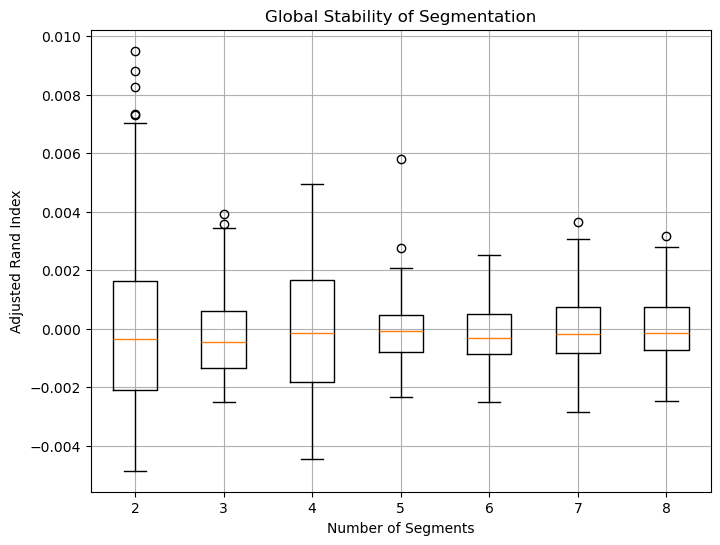

In [26]:
# Stability analysis using K-Means clustering
num_segments = range(2, 9)
n_boot = 100
stability_scores = []

for k in num_segments:
    rand_indices = []
    for _ in range(n_boot):
        sample_idx = np.random.choice(len(MD_x), len(MD_x), replace=True)
        sample_data = MD_x.iloc[sample_idx]
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=None).fit(sample_data)
        ref_kmeans = KMeans(n_clusters=k, n_init=10, random_state=None).fit(MD_x)
        rand_indices.append(adjusted_rand_score(ref_kmeans.labels_, kmeans.labels_))
    stability_scores.append(rand_indices)

# Boxplot of stability scores
plt.figure(figsize=(8, 6))
plt.boxplot(stability_scores, labels=num_segments)
plt.xlabel("Number of Segments")
plt.ylabel("Adjusted Rand Index")
plt.title("Global Stability of Segmentation")
plt.grid()
plt.show()


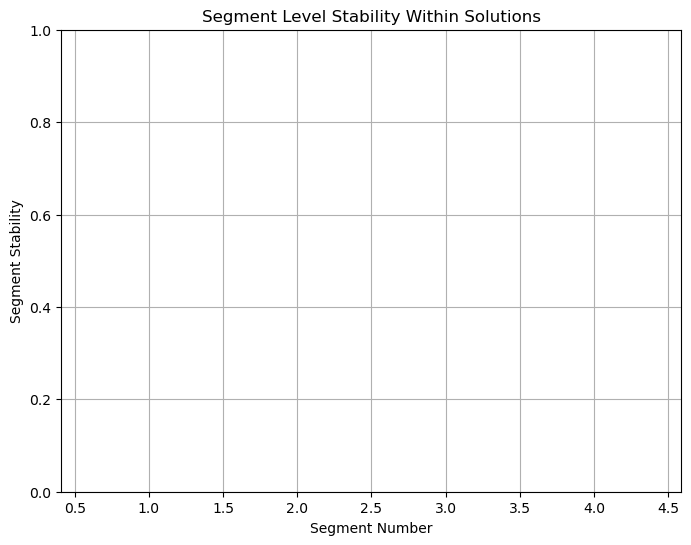

In [37]:
# Selecting the best segmentation solution
best_k = 4
final_kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit(MD_x)
mcdonalds["Segment"] = final_kmeans.labels_

# Segment Level Stability Within Solutions (SLSW)
segment_stability = []
for segment in range(best_k):
    segment_indices = (final_kmeans.labels_ == segment)
    intra_stability = np.mean([adjusted_rand_score(final_kmeans.labels_[segment_indices], KMeans(n_clusters=best_k, n_init=10, random_state=None).fit(MD_x.iloc[segment_indices]).labels_) for _ in range(n_boot)])
    segment_stability.append(intra_stability)

# Plot segment stability
plt.figure(figsize=(8, 6))
plt.bar(range(1, best_k+1), segment_stability)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.title("Segment Level Stability Within Solutions")
plt.ylim(0, 1)
plt.grid()
plt.show()


/var/folders/ns/_gksq54x6hq35t894m1570280000gn/T/ipykernel_5408/1934968170.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = mcdonalds.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0)


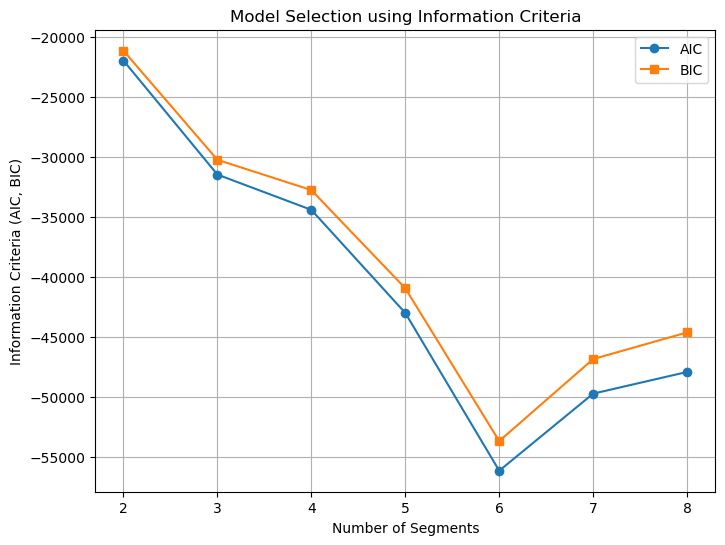


Cross-tabulation of K-Means and GMM Segments:
 GMM_Segment       0    1    2    3
KMeans_Segment                    
0                 4  213    0   23
1               120    0  403   26
2                26   52  227    4
3                28    3    0  324

Log-Likelihood Values:
Random Initialization: 17513.53905912311
K-Means Initialization: 17513.53905912311


In [41]:


# Convert segmentation variables from Yes/No to binary numeric
MD_x = mcdonalds.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0)

# Fit Gaussian Mixture Model (GMM) for 2 to 8 segments
num_segments = range(2, 9)
gmm_models = {}
log_likelihoods = []
aic_values = []
bic_values = []

for k in num_segments:
    gmm = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    gmm_models[k] = gmm
    log_likelihoods.append(gmm.lower_bound_ * MD_x.shape[0])
    aic_values.append(gmm.aic(MD_x))
    bic_values.append(gmm.bic(MD_x))

# Plot Information Criteria
plt.figure(figsize=(8, 6))
plt.plot(num_segments, aic_values, label='AIC', marker='o')
plt.plot(num_segments, bic_values, label='BIC', marker='s')
plt.xlabel("Number of Segments")
plt.ylabel("Information Criteria (AIC, BIC)")
plt.title("Model Selection using Information Criteria")
plt.legend()
plt.grid()
plt.show()

# Select best number of segments (based on elbow method, e.g., 4)
best_k = 4
best_gmm = gmm_models[best_k]
mcdonalds["GMM_Segment"] = best_gmm.predict(MD_x)

# Compare with K-Means clustering
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit(MD_x)
mcdonalds["KMeans_Segment"] = kmeans.labels_

# Cross-tabulation of segments
cross_tab = pd.crosstab(mcdonalds["KMeans_Segment"], mcdonalds["GMM_Segment"])
print("\nCross-tabulation of K-Means and GMM Segments:\n", cross_tab)

# Initializing GMM using K-Means clusters
gmm_kmeans_init = GaussianMixture(n_components=best_k, n_init=10, random_state=1234, init_params='kmeans')
gmm_kmeans_init.fit(MD_x)
mcdonalds["GMM_KMeansInit_Segment"] = gmm_kmeans_init.predict(MD_x)

# Compare log-likelihood values
print("\nLog-Likelihood Values:")
print("Random Initialization:", best_gmm.lower_bound_ * MD_x.shape[0])
print("K-Means Initialization:", gmm_kmeans_init.lower_bound_ * MD_x.shape[0])


/var/folders/ns/_gksq54x6hq35t894m1570280000gn/T/ipykernel_5408/1622017903.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = mcdonalds.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0)
/var/folders/ns/_gksq54x6hq35t894m1570280000gn/T/ipykernel_5408/1622017903.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_segment = sm.add_constant(segment_data.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0))
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/var/folders/ns/_gksq54x6hq35t894m1570280000gn/T/ipykernel_5408/1622017903.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_segment = sm.add_constant(segment_data.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0))



Segment 1 Regression Results:
                            OLS Regression Results                            
Dep. Variable:                 Like.n   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     83.00
Date:                Mon, 10 Feb 2025   Prob (F-statistic):          1.34e-104
Time:                        21:04:37   Log-Likelihood:                -1982.1
No. Observations:                 985   AIC:                             3982.
Df Residuals:                     976   BIC:                             4026.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yummy          1.9765

<Figure size 1000x600 with 0 Axes>

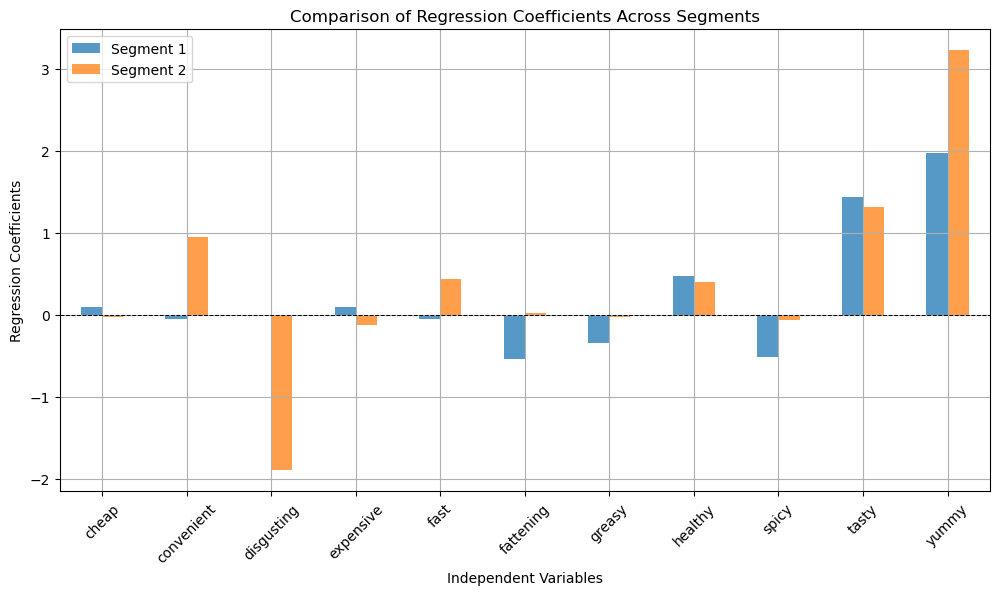

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.mixture import GaussianMixture



# Mapping for 'Like' column to numerical values
like_mapping = {
    "I love it!+5": 5, "+4": 4, "+3": 3, "+2": 2, "+1": 1, "0": 0,
    "-1": -1, "-2": -2, "-3": -3, "-4": -4, "I hate it!-5": -5
}

# Convert categorical 'Like' variable to numerical scale (-5 to +5)
mcdonalds['Like.n'] = mcdonalds['Like'].map(like_mapping)

# Drop rows where Like.n could not be mapped
mcdonalds = mcdonalds.dropna(subset=['Like.n'])

# Define dependent variable (y) and independent variables (X)
X = mcdonalds.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0)
y = mcdonalds['Like.n']

# Fit a mixture of regression models with 2 components
num_components = 2
gmm = GaussianMixture(n_components=num_components, n_init=10, random_state=1234)
clusters = gmm.fit_predict(X)
mcdonalds['GMM_Cluster'] = clusters

# Fit separate regression models for each segment
regression_results = {}
for segment in range(num_components):
    segment_data = mcdonalds[mcdonalds['GMM_Cluster'] == segment]
    X_segment = sm.add_constant(segment_data.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0))
    y_segment = segment_data['Like.n']
    model = sm.OLS(y_segment, X_segment).fit()
    regression_results[segment] = model
    print(f"\nSegment {segment + 1} Regression Results:")
    print(model.summary())

# Extract regression coefficients for plotting
coefficients = pd.DataFrame({f'Segment {i+1}': model.params for i, model in regression_results.items()})
coefficients = coefficients.drop("const")

# Plot regression coefficients
plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar', figsize=(12, 6), alpha=0.75)
plt.axhline(y=0, color='black', linewidth=0.75, linestyle='--')
plt.xlabel("Independent Variables")
plt.ylabel("Regression Coefficients")
plt.title("Comparison of Regression Coefficients Across Segments")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()
